![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2Farchitectures%2Ftracking%2Fsetup%2Fga4&file=GA4+Reporting.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/architectures/tracking/setup/ga4/GA4%20Reporting.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2Farchitectures%2Ftracking%2Fsetup%2Fga4%2FGA4%2520Reporting.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/architectures/tracking/setup/ga4/GA4%20Reporting.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/architectures/tracking/setup/ga4/GA4%20Reporting.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

## GA4 Reporting

This notebook shows the processing of the raw GA4 data exported to BigQuery into a format ready for reporting.  This is specific the GA4 data collected in this series which basically captures file names, locations, and timestamps within the overall GA4 schema.

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/architectures/tracking/setup/ga4/GA4%20Reporting.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'vertex-ai-mlops-369716' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

Updated property [core/project].


---
## Setup

In [3]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'vertex-ai-mlops-369716'

In [17]:
BQ_PROJECT = PROJECT_ID

In [5]:
from google.cloud import bigquery

In [6]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Diagnostics

A Series of queries used to understand the tables

In [18]:
BQ_DATASET = 'analytics_343629755'
BQ_TABLE = 'events_intraday_20230127'

In [19]:
BQ_SOURCE = f"`{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`"

In [11]:
# how many transactions total?
query = f"""
SELECT count(*) as counter
FROM {BQ_SOURCE}
"""
bq.query(query).to_dataframe()['counter'].iloc[0]

291

In [12]:
# how many timestamps with exactly 1 transaction?
query = f"""
WITH
  raw AS (
    SELECT event_timestamp, count(*) as counter
    FROM {BQ_SOURCE}
    GROUP BY event_timestamp
  )
SELECT count(*) as counter
FROM raw
WHERE counter = 1
"""
bq.query(query).to_dataframe()['counter'].iloc[0]

291

In [15]:
# how many transactions have a page_location - the file path?
query = f"""
SELECT count(*) as counter
FROM {BQ_SOURCE},
UNNEST(event_params) as keys
WHERE keys.key ='page_location'
"""
bq.query(query).to_dataframe()['counter'].iloc[0]

291

In [16]:
# how many transactions have a page_title - the file name?
query = f"""
SELECT count(*) as counter
FROM {BQ_SOURCE},
UNNEST(event_params) as keys
WHERE keys.key ='page_title'
"""
bq.query(query).to_dataframe()['counter'].iloc[0]

291

In [22]:
# convert the raw events transaction into a simple table: event_date, file (location+file), loads (count of loads for the event_date)
query = f"""
  WITH DAILY AS (
    SELECT
      event_timestamp,
      STRING_AGG(keys.value.string_value, '/' ORDER BY keys.key) as file
    FROM {BQ_SOURCE},
      UNNEST(event_params) as keys
    WHERE keys.key IN ('page_location', 'page_title')
    GROUP BY event_timestamp
  )
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp)) as event_date, 
    file, 
    COUNT(*) as loads
  FROM DAILY
  GROUP BY event_date, file
"""
results = bq.query(query).to_dataframe()
results

,event_date,file,loads
0,2023-01-27,statmike/vertex-ai-mlops/99 - Cleanup/99 - Cle...,6
1,2023-01-27,statmike/vertex-ai-mlops/readme.md,92
2,2023-01-27,statmike/vertex-ai-mlops/02 - Vertex AI AutoML...,2
3,2023-01-27,statmike/vertex-ai-mlops/03 - BigQuery ML (BQM...,17
4,2023-01-27,statmike/vertex-ai-mlops/01 - Data Sources/rea...,5
5,2023-01-27,statmike/vertex-ai-mlops/04 - scikit-learn/rea...,27
6,2023-01-27,GoogleCloudPlatform/bigquery_ml_utils/notebook...,36
7,2023-01-27,statmike/vertex-ai-mlops/03 - BigQuery ML (BQM...,17
8,2023-01-27,statmike/vertex-ai-mlops/05 - TensorFlow/readm...,6
9,2023-01-27,statmike/vertex-ai-mlops/04 - scikit-learn/04a...,2


In [23]:
results['loads'].sum()

291

In [25]:
results.groupby(['event_date']).sum()

,loads
event_date,
2023-01-27,254
2023-01-28,37


While the table is for a single day, it appears to have records for two different dates.  This is likely due to timezone.  When setting up GA4 it had me select a timezone.  In my case EST which is UTC−05:00.  The next query applies the EST timezone when converting the `event_timestamp` into a date.

In [26]:
# convert the raw events transaction into a simple table: event_date, file (location+file), loads (count of loads for the event_date)
query = f"""
  WITH DAILY AS (
    SELECT
      event_timestamp,
      STRING_AGG(keys.value.string_value, '/' ORDER BY keys.key) as file
    FROM {BQ_SOURCE},
      UNNEST(event_params) as keys
    WHERE keys.key IN ('page_location', 'page_title')
    GROUP BY event_timestamp
  )
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp) AT TIME ZONE '-05') as event_date, 
    file, 
    COUNT(*) as loads
  FROM DAILY
  GROUP BY event_date, file
"""
results = bq.query(query).to_dataframe()
results['loads'].sum()

291

In [27]:
results.groupby(['event_date']).sum()

,loads
event_date,
2023-01-27,291


By applying the correct timezone the counts are correct and all associated with the date that the table represents.  This is now the basis for the initial reporting table and the incremental load process.

---
## Initial Reporting Table

This section creates and runs the query that takes all GA4 data to date an creates a reporting table.  The next section will build the query that incrementally updates this initial table.

In [ ]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.reporting.daily_loads` AS
  WITH DAILY AS (
    SELECT
      event_timestamp,
      STRING_AGG(keys.value.string_value, '/' ORDER BY keys.key) as file
    FROM `{BQ_PROJECT}.{BQ_DATASET}.events_intraday_*`,
      UNNEST(event_params) as keys
    WHERE keys.key IN ('page_location', 'page_title')
    GROUP BY event_timestamp
  )
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp) AT TIME ZONE '-05') as event_date, 
    file, 
    COUNT(*) as loads
  FROM DAILY
  GROUP BY event_date, file
"""
job = bq.query(query)
job.result()

View this table in the console:

In [28]:
print(f"View the daily_loads table in the console:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2sreporting!3sdaily_loads")

View the daily_loads table in the console:
https://console.cloud.google.com/bigquery?project=vertex-ai-mlops-369716&ws=!1m5!1m4!4m3!1svertex-ai-mlops-369716!2sreporting!3sdaily_loads


---
## Incremental Updates to Reporting Table

Building on the query that create the reporting table `reporting.daily_loads` while making it efficient so that it only queries recent daily data and not full tables:
- `reporting.daily_loads`
  - remove data for yesterday and today - the last run may have inserted incomplete data for today
  - insert new records for yesterday and today only by only processing data for yesterday and today

This query can be run at any time the `reporting.daily_loads` table needs updating without damaging the history of the table or creating a large, potentially expensive, full table query.

In [29]:
query = f"""
DELETE
  FROM `{BQ_PROJECT}.reporting.daily_loads`
  WHERE event_date >= DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY);
INSERT INTO `{BQ_PROJECT}.reporting.daily_loads`
  WITH
    RAW AS (
      SELECT event_timestamp, event_params
      FROM `{BQ_PROJECT}.{BQ_DATASET}.events_intraday_*`
      WHERE
        _TABLE_SUFFIX >= FORMAT_DATE('%Y%m%d', DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY))
    ),
    DAILY AS (
      SELECT
        event_timestamp,
        STRING_AGG(keys.value.string_value, '/' ORDER BY keys.key) as file
      FROM RAW, UNNEST(event_params) as keys
      WHERE keys.key IN ('page_location', 'page_title')
      GROUP BY event_timestamp
    )
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp) AT TIME ZONE '-05') as event_date, 
    file, 
    COUNT(*) as loads
  FROM DAILY
  GROUP BY event_date, file
"""
print(query)


DELETE
  FROM `vertex-ai-mlops-369716.reporting.daily_loads`
  WHERE event_date >= DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY);
INSERT INTO `vertex-ai-mlops-369716.reporting.daily_loads`
  WITH
    RAW AS (
      SELECT event_timestamp, event_params
      FROM `vertex-ai-mlops-369716.analytics_343629755.events_intraday_*`
      WHERE
        _TABLE_SUFFIX >= FORMAT_DATE('%Y%m%d', DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY))
    ),
    DAILY AS (
      SELECT
        event_timestamp,
        STRING_AGG(keys.value.string_value, '/' ORDER BY keys.key) as file
      FROM RAW, UNNEST(event_params) as keys
      WHERE keys.key IN ('page_location', 'page_title')
      GROUP BY event_timestamp
    )
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp) AT TIME ZONE '-05') as event_date, 
    file, 
    COUNT(*) as loads
  FROM DAILY
  GROUP BY event_date, file



In [ ]:
job = bq.query(query)

In [31]:
job.result()

In [33]:
job.state

'DONE'

In [45]:
str(job.total_bytes_processed/1000000) + 'MB'

'0.325168MB'

---
## Schedule Query

The easiest way to schedule a single query like this is using the BigQuery console.

Two Paths to Start:
- From the query editor
- From the BigQuery > Schedule Queries > + Create Scheduled Query In Editor

Paste in the Query printed in the previous section:


In [46]:
print(query)


DELETE
  FROM `vertex-ai-mlops-369716.reporting.daily_loads`
  WHERE event_date >= DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY);
INSERT INTO `vertex-ai-mlops-369716.reporting.daily_loads`
  WITH
    RAW AS (
      SELECT event_timestamp, event_params
      FROM `vertex-ai-mlops-369716.analytics_343629755.events_intraday_*`
      WHERE
        _TABLE_SUFFIX >= FORMAT_DATE('%Y%m%d', DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY))
    ),
    DAILY AS (
      SELECT
        event_timestamp,
        STRING_AGG(keys.value.string_value, '/' ORDER BY keys.key) as file
      FROM RAW, UNNEST(event_params) as keys
      WHERE keys.key IN ('page_location', 'page_title')
      GROUP BY event_timestamp
    )
  SELECT
    EXTRACT(DATE FROM TIMESTAMP_MICROS(event_timestamp) AT TIME ZONE '-05') as event_date, 
    file, 
    COUNT(*) as loads
  FROM DAILY
  GROUP BY event_date, file



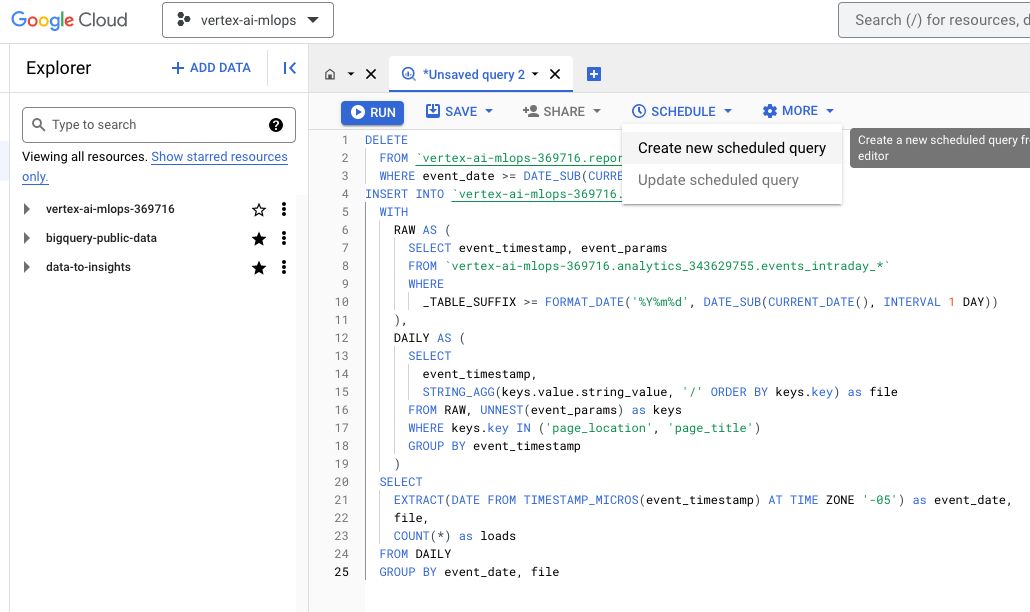

In the fly-over menu specify:
- a name for the query
- Repeat frequency, select Days to run once per day
- Enter a time to run the query in UTC.  I want this to run at 3AM EST each day so I enter 08:00 for UTC-05:00 (EST time zone)
- other options are default/blank since the query is controlling the destination table

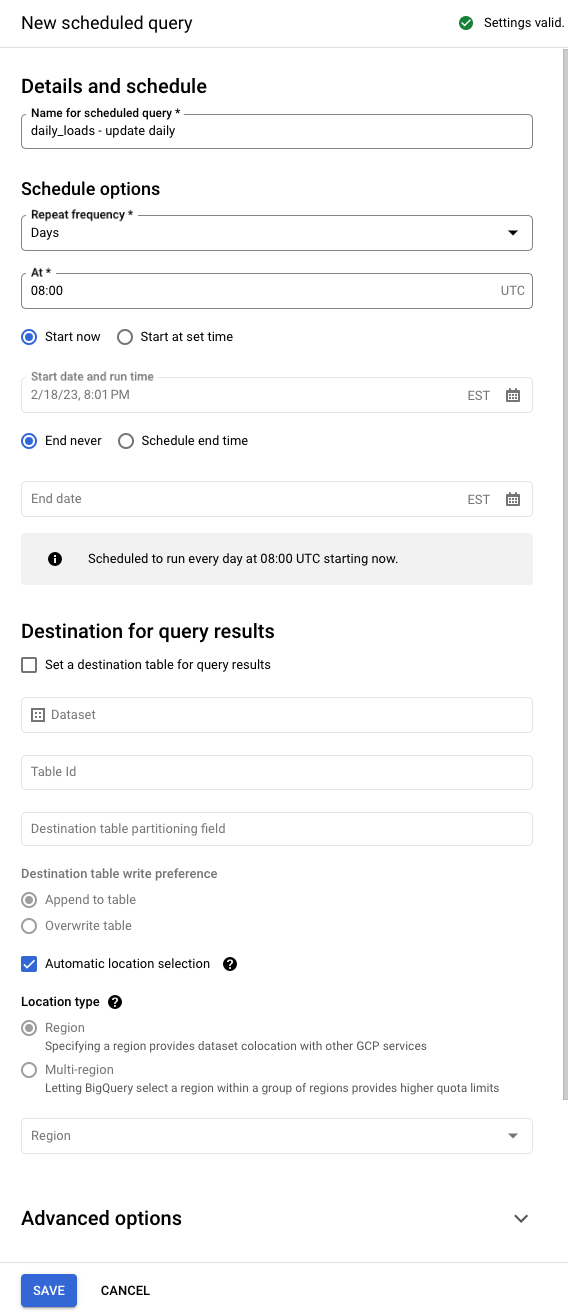

The query now shows up as a schedule query in the console:

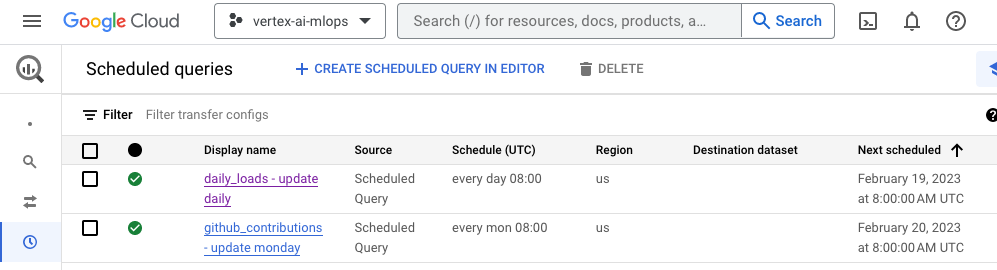

In [47]:
print(f"Link to Schedule Query Console Page:\nhttps://console.cloud.google.com/bigquery/scheduled-queries?project={PROJECT_ID}")

Link to Schedule Query Console Page:
https://console.cloud.google.com/bigquery/scheduled-queries?project=vertex-ai-mlops-369716
